This notebook filters existing Stanford + LPCH reports, creates unique report-signal pairs, and assigns the label from each report to any signals to which it correponds.  

There could be more intelligent ways to do this -- document and ask CLM!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import pandas as pd
import numpy as np

In [3]:
from sqlalchemy import create_engine

# Getting location of source db and setting up sqlalchemy engine
db_location = '/Users/jdunnmon/Research/projects/eeg/data/stanford_reports/eegml-tracking-db-2018/var/db/'
db_name = 'trackingdb-main.db'
db_path = '{0}:///{1}/{2}'.format("sqlite", db_location, db_name)
engine = create_engine(db_path)

In [4]:
import sqlite3
import os

# Getting table names from db
con = sqlite3.connect(os.path.join(db_location,db_name))
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('user',), ('role',), ('patient',), ('subject_code',), ('eeg_study',), ('problem_eeg_file',), ('roles_users',), ('mrn',), ('eeg_file',), ('study_segment',), ('alembic_version',), ('nk_exam',), ('nk_patient',), ('nk_mrn',), ('nk_study',), ('source_database',)]


In [37]:
# Getting table with subject code
subject_code_table = pd.read_sql_table('subject_code',engine)

# read in all reports, associate with subject code
impress_csv = '/Users/jdunnmon/Research/projects/eeg/data/stanford_reports/eegml-tracking-db-2018/reports-parsing/ALL_NOTES_IMPRESS_.csv'
impress_table = pd.read_csv(impress_csv, dtype=str)

# reading in all notes
all_notes_csv = '/Users/jdunnmon/Research/projects/eeg/data/stanford_reports/patient_reports/CleanedReportsCSV/ALL_NOTES_IMPRESS_based_upon_messer_ALL_note_final_2_cleaned_2018-06-28.csv'
all_notes_table = pd.read_csv(all_notes_csv, sep=',', dtype=str)

# filtering EEG reports
all_notes_table = all_notes_table[all_notes_table['Note_type_Desc'].str.contains('EEG')]

# Getting Packard + Stanford files 
packard_files_csv = '/Users/jdunnmon/Research/projects/eeg/data/stanford_reports/eegml-tracking-db-2018/var/db/LPCH_FILES_COMPLETEINFO.csv'
stanford_files_csv = '/Users/jdunnmon/Research/projects/eeg/data/stanford_reports/eegml-tracking-db-2018/var/db/STANFORD_FILES_ALL.csv'
files_table = pd.read_csv(packard_files_csv, sep=',', dtype=str)
#files_table = files_table.merge(pd.read_csv(stanford_files_csv, sep=',', dtype=str),how='outer')
files_table['eegno'] = files_table['eegno'].str.lower()
files_table['id'] = pd.to_numeric(files_table['id'])

# Merging subject codes with note info on MRN
merge_all_sc = subject_code_table.merge(all_notes_table, how='inner')
merge_all_sc['examno'] = merge_all_sc['examno'].str.lower()

# Merging files with subject code + note info
merge_all_sc_file = merge_all_sc.merge(
    files_table, left_on=['id','mrn','examno','subject_code_ec','subject_name_ec'],\
    right_on = ['id','mrn','eegno','subject_code_ec','subject_name_ec'], how='inner',suffixes=['',''])

# Filtering out duplicate file - node id pairs
reports_unique = merge_all_sc_file.drop_duplicates(subset=['note_uuid','edf_file_name']).reset_index()

# Setting EEG db for parsing
df_eeg = reports_unique
df_eeg['note'] = df_eeg['Note']
df_eeg['hand_label'] = np.nan
print(len(df_eeg))

49070


In [38]:
# Creating MRN hash table
import hashlib
def sha256(n):
    return hashlib.sha256(str(n).encode('utf-8')).hexdigest()

mrn_table = files_table.drop_duplicates(subset=['edf_file_name','mrn']).reset_index(drop=True)
mrn_table = mrn_table[['edf_file_name','mrn']]
print(len(mrn_table['mrn'].unique()))
print(len(mrn_table['edf_file_name'].unique()))
mrn_table['hsh'] = mrn_table['mrn'].apply(sha256)
print(len(mrn_table['hsh'].unique()))

# Saving hash table
#mrn_table[['edf_file_name','hsh']].to_csv('eeg_hash_table.csv', index=False)

5076
36642
5076


In [34]:
mrn_table.iloc[0]

edf_file_name                                    AA3320DF_1-1+.edf
mrn                                                       46390936
hsh              145925115f49155f2918012ed5ca1e9118a3d513f08c00...
Name: 0, dtype: object

In [6]:
# Parsing all files
import dill
from eeg_utils import parse_eeg_docs

eeg_data_path = '/Users/jdunnmon/Research/projects/eeg/data/hand_labels/reports_08_11_2018'
eeg_note_dill = 'parsed_eeg_notes_eval.dill'
eeg_note_dill_path = os.path.join(eeg_data_path, eeg_note_dill)

if os.path.exists(eeg_note_dill_path):
    print('Loading pre-parsed EEG notes...')
    with open(eeg_note_dill_path, 'rb') as af:
        docs = dill.load(af)
else:
    print('Parsing EEG notes...')
    docs = parse_eeg_docs(df_eeg, use_dask=False)
    with open(eeg_note_dill_path,'wb') as af:
        dill.dump(docs, af)

Loading pre-parsed EEG notes...


In [7]:
len(df_eeg)

49176

In [8]:
from eeg_lfs import *

# Putting in lfs -- this should probably be in the eeg_lfs file!
lfs = [
    lf_normal_interp_not_seizure,
    lf_abnormal_interp_with_seizure,
    lf_findall_interp_with_seizure,
    lf_findall_abnl_interp_without_seizure,
    lf_abnl_interp_negexsp_seizure,
    lf_findall_interp_negex_seizure,
    lf_seizure_section,
    lf_impression_section_negative,
    lf_impression_section_positive,
    lf_spikes_in_impression,
    lf_extreme_words_in_impression
]

In [9]:
# Loading files for eval
#seizure_file = '/Users/jdunnmon/Research/projects/eeg/data/ks_files/seizure_files.txt'
#non_seizure_file = '/Users/jdunnmon/Research/projects/eeg/data/ks_files/nonSeizure_files.txt'

seizure_file = '/Users/jdunnmon/Research/projects/eeg/data/ks_files/lpch_seizures_train.txt'
non_seizure_file = '/Users/jdunnmon/Research/projects/eeg/data/ks_files/lpch_nonSeizures_train.txt'

# Creating file lists
file_lists = {}
file_lists['seizure'] = pd.read_csv(seizure_file,sep='\t',header=None,names=['edf_file_name'])
file_lists['non_seizure'] = pd.read_csv(non_seizure_file,sep='\t',header=None,names=['edf_file_name'])

In [10]:
from eeg_utils import create_label_matrix
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
splits = ['seizure','non_seizure']
Ls = {}
eval_inds = defaultdict(list)
eval_df = {}
L_doc_ids = defaultdict(list)

# Getting all filenames in parsed EEG notes -- 29K of these
eeg_filenames = [a.split('.')[0] for a in  df_eeg['edf_file_name']]

for split in splits:
    print (f'Evaluating union for {split} cases...')
    # Getting filenames for given split 
    split_filenames = [a.split('.')[0] for a in  file_lists[split]['edf_file_name']]
    # Getting union of filenames with parsed EEG notes
    union_filenames = list(set(split_filenames).intersection(set(eeg_filenames)))
    print(f'{len(union_filenames)} {split} filenames found...')
    # For each EEG Note - File combination, add to eval dataframe
    for ii, row in tqdm(df_eeg.iterrows(), total=len(df_eeg)):
        file_prefix = row['edf_file_name'].split('.')[0]
        if file_prefix in union_filenames:
            eval_inds[split].append(ii)
    
    # Subsetting dataframes
    eval_df[split] = df_eeg.iloc[eval_inds[split]]
    
    # Reset indices to zero
    eval_df[split] = eval_df[split].reset_index()

Evaluating union for seizure cases...
3799 seizure filenames found...



Evaluating union for non_seizure cases...
19107 non_seizure filenames found...


In [11]:
import pickle
for split in splits:
    print(f'{len(eval_df[split])} {split} note-signal pairs...')
    unique_docs = len(eval_df[split]['note_uuid'].unique())
    print(f'{unique_docs} {split} unique documents...')
    unique_signals = len(eval_df[split]['edf_file_name'].unique())
    print(f'{unique_signals} {split} unique signals...')
    print('\n')
#for split in splits:
#    eval_df[split].to_csv(f'reoprts_df_temp_{split}.tsv',sep='\t')

10028 seizure note-signal pairs...
1031 seizure unique documents...
3799 seizure unique signals...


32634 non_seizure note-signal pairs...
5576 non_seizure unique documents...
19107 non_seizure unique signals...




In [70]:
# Parsing documents and creating label matrices
split_docs = {}
for split in splits:
    # Parse EEG notes
    split_docs[split] = parse_eeg_docs(eval_df[split])
    
    # Create lable matrix
    Ls[split] = create_label_matrix(lfs,split_docs[split])

100%|██████████| 10028/10028 [05:56<00:00, 28.11it/s]


[################################        ] | 81% Completed |  1min 41.9s


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jdunnmon/Research/repos/anaconda3/anaconda3/envs/metal/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-71bfa800cb18>", line 8, in <module>
    Ls[split] = create_label_matrix(lfs,split_docs[split])
  File "/Users/jdunnmon/Research/projects/xmodal/eeg/eeg_utils.py", line 28, in create_label_matrix
    L = csr_matrix(np.vstack(dask.compute(*delayed_lf_rows)).transpose())
  File "/Users/jdunnmon/Research/repos/anaconda3/anaconda3/envs/metal/lib/python3.6/site-packages/dask/base.py", line 402, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/Users/jdunnmon/Research/repos/anaconda3/anaconda3/envs/metal/lib/python3.6/site-packages/dask/threaded.py", line 75, in get
    pack_exception=pack_exception, **kwargs)
  File "/Users/jdunnmon/Research/repos/anaconda3/anaconda3/envs/metal/lib/python3.6/site-packages/dask/l

KeyboardInterrupt: 

In [15]:
from eeg_utils import unpickle_model

# Import trained label model
#model_loc = '/Users/jdunnmon/Research/projects/xmodal/eeg/results/eeg_run_09072018'
model_loc = '/Users/jdunnmon/Research/projects/xmodal/eeg/results/run_logs/2018_11_01/22_10_36'
model_path = os.path.join(model_loc,'best_model.pkl')
label_model = unpickle_model(model_path)

In [97]:
from collections import Counter

Y_ps = {}
L_files = {}
save_dest = '/Users/jdunnmon/Research/projects/xmodal/eeg/results/run_logs/2018_11_01/22_10_36'
if not os.path.exists(save_dest):
    os.makedirs(save_dest)
for split in splits:
    # Get probabilistic labels in list form
    Y_ps[split] = label_model.predict_proba(Ls[split])
    Y_rows = [y for y in Y_ps[split]]    

    # Get rows of label matrix in list form
    L_rows = [Ls[split][ind,:].todense() for ind in range(Ls[split].shape[0])]
    
    # Getting majority vote output
    Y_mv = []
    for row in L_rows:
        cnt = Counter(row.tolist()[0])
        if not cmm:
            lab = [0.5, 0.5]
        elif cnt[1]>cnt[2]:
            lab = [1.0, 0.0]
        elif cnt[2]>cnt[1]:
            lab = [0.0, 1.0]
        elif cnt[1] == cnt[2]:
            lab = [0.5, 0.5]
        Y_mv.append(lab)
    
    # Create dictionary for output
    df_dict = {'id': eval_df[split]['note_uuid'].tolist(),\
               'file_name':eval_df[split]['edf_file_name'].tolist(),\
               'text_gm_marginals':Y_rows,\
               'text_mv_output':Y_mv,
               'L_row':L_rows }
    
    # Save results
    df_out = pd.DataFrame(df_dict)
    #df_out.to_csv(os.path.join(save_dest, f'metal_results_lpch_{split}.tsv'),sep='\t')

## SANDBOX

In [227]:
from tqdm import tqdm
sm = []
for a in tqdm(range(len(reports_unique['note_uuid'].unique())), total=len(reports_unique['note_uuid'].unique())):
    sm.append(len(reports_unique[reports_unique['note_uuid'] == reports_unique['note_uuid'].unique()[a]]))

100%|██████████| 6267/6267 [01:06<00:00, 93.78it/s]


In [62]:
lb = [np.round(a[0]) for a in Y_ps['non_seizure']]
np.sum(lb)/len(lb)

0.28335478335478337

In [ ]:
Y_ps

In [241]:
max_report = reports_unique['note_uuid'].unique()[sm.index(max(sm))]
max_report
df_max = reports_unique[reports_unique['note_uuid'] == max_report]
cols = list(df_max)
nunique = df_max.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_max = df_max.drop(cols_to_drop, axis=1)
len(df_max['edf_file_name'].unique())

238

In [245]:
df_max

,index,eeg_file_fk,edf_file_name,nk_file_reportkey,start_dt,end_dt,name,dob,id.1
7793,8478,15323,CA8313KX_1-1+.edf,CA8313KX,2012-09-18 06:21:57.000000,2012-09-18 06:22:22.000000,NaN,NaN,NaN
7794,8479,15324,CA8313KX_1-2+.edf,CA8313KX,2012-09-18 07:42:17.000000,2012-09-18 07:44:31.000000,NaN,NaN,NaN
7795,8480,15371,CA8313KR_1-1+.edf,CA8313KR,2012-09-17 13:57:33.000000,2012-09-17 14:00:02.000000,NaN,NaN,NaN
7796,8481,15372,CA8313KR_1-2+.edf,CA8313KR,2012-09-17 14:20:07.000000,2012-09-17 14:20:37.000000,NaN,NaN,NaN
7797,8482,15514,CA8313KS_1-1+.edf,CA8313KS,2012-09-17 14:46:15.000000,2012-09-17 14:50:03.000000,NaN,NaN,NaN
7798,8483,15531,CA8313KY_1-1+.edf,CA8313KY,2012-09-18 05:56:18.000000,2012-09-18 06:00:17.000000,NaN,NaN,NaN
7799,8484,15916,CA75506B_1-1+.edf,CA75506B,2012-09-14 08:03:48.000000,2012-09-14 08:09:27.000000,NaN,NaN,NaN
7800,8485,16287,CA8313KU_1-1+.edf,CA8313KU,2012-09-17 16:33:49.000000,2012-09-17 16:34:51.000000,NaN,NaN,NaN
7801,8486,16288,CA8313KU_1-2+.edf,CA8313KU,2012-09-17 17:47:21.000000,2012-09-17 17:48:04.000000,NaN,NaN,NaN
7802,8487,16289,CA8313KU_1-3+.edf,CA8313KU,2012-09-17 18:08:42.000000,2012-09-17 18:09:11.000000,NaN,NaN,NaN


In [244]:
len(reports_unique['edf_file_name'].unique())

26289

(array([5680.,  406.,   78.,   52.,   18.,   25.,    0.,    0.,    0.,
           8.]),
 array([  1. ,  24.7,  48.4,  72.1,  95.8, 119.5, 143.2, 166.9, 190.6,
        214.3, 238. ]),
 <a list of 10 Patch objects>)

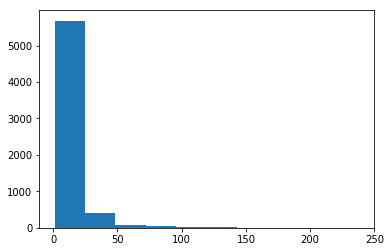

In [229]:
from matplotlib.pyplot import hist
hist(sm)

In [64]:
from collections import defaultdict
rep_sig_dict = defaultdict(list)
sig_rep_dict = defaultdict(list)
for i, row in df_eeg.iterrows():
    sig_rep_dict[row['edf_file_name']].append(row['note_uuid'])
    rep_sig_dict[row['note_uuid']].append(row['edf_file_name'])
    

In [65]:
rep_lens = []
sig_lens = []
for i, aa in rep_sig_dict.items():
    rep_lens.append(len(aa))
for i, bb in sig_rep_dict.items():
    sig_lens.append(len(bb))

(array([1.8208e+04, 2.3650e+03, 2.5820e+03, 9.7200e+02, 9.8500e+02,
        5.5800e+02, 4.0000e+01, 2.6900e+02, 1.1000e+01]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

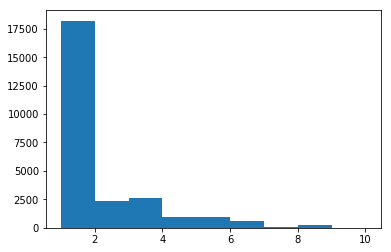

In [66]:
import matplotlib.pyplot as plt
plt.hist(sig_lens,[1,2,3,4,5,6,7,8,9,10])

(array([3687.,  530.,  169.,  142.,  101.,   95.,  102.,   85.,   78.,
         549.,  283.,  166.,  103.,   53.,   21.,    7.,   36.,   16.]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  20,  30,  40,
         50,  60,  70,  80,  90, 100]),
 <a list of 18 Patch objects>)

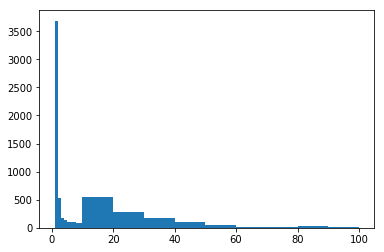

In [69]:
plt.hist(rep_lens,[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100])

In [ ]:
df_eeg.groupby('edf_file').apply(lambda x: x.loc[x..idxmax(),['date','value']]).reset_index()


In [81]:
from collections import Counter
x = Counter(sig_lens).most_common()
sorted(x, key=lambda pair: pair[0])

[(1, 18208),
 (2, 2365),
 (3, 2582),
 (4, 972),
 (5, 985),
 (6, 558),
 (7, 40),
 (8, 269),
 (10, 11),
 (11, 134),
 (13, 81),
 (15, 83),
 (17, 1)]

In [82]:
x = Counter(rep_lens).most_common()
sorted(x, key=lambda pair: pair[0])

[(1, 3687),
 (2, 530),
 (3, 169),
 (4, 142),
 (5, 101),
 (6, 95),
 (7, 102),
 (8, 85),
 (9, 78),
 (10, 80),
 (11, 80),
 (12, 57),
 (13, 65),
 (14, 50),
 (15, 44),
 (16, 50),
 (17, 39),
 (18, 46),
 (19, 38),
 (20, 30),
 (21, 16),
 (22, 22),
 (23, 37),
 (24, 37),
 (25, 38),
 (26, 29),
 (27, 19),
 (28, 27),
 (29, 28),
 (30, 22),
 (31, 14),
 (32, 17),
 (33, 11),
 (34, 15),
 (35, 29),
 (36, 14),
 (37, 14),
 (38, 18),
 (39, 12),
 (40, 30),
 (41, 18),
 (42, 2),
 (43, 2),
 (44, 10),
 (45, 18),
 (46, 10),
 (47, 5),
 (48, 4),
 (49, 4),
 (50, 8),
 (52, 5),
 (53, 7),
 (54, 8),
 (55, 3),
 (56, 4),
 (57, 12),
 (58, 6),
 (60, 1),
 (61, 1),
 (62, 3),
 (63, 5),
 (64, 4),
 (66, 3),
 (67, 3),
 (69, 1),
 (75, 3),
 (76, 4),
 (81, 13),
 (83, 21),
 (87, 2),
 (93, 3),
 (94, 6),
 (99, 6),
 (100, 1),
 (101, 5),
 (102, 2),
 (107, 3),
 (115, 1),
 (121, 6),
 (123, 1),
 (125, 6),
 (128, 1),
 (134, 11),
 (238, 8)]